## Stackoverflow tag recommendation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
import gensim
from model import ConvText

random_state = 747

## Question Data

Stackoverflow question data downloaded from Google BigQuery and aggregated into a single csv file. 

In [ ]:
file = '../../../Data/stackoverflow/questions.csv'
df = pd.read_csv(file, usecols=['title', 'tags'])
df.head(10)

Data size

In [ ]:
df.shape

### Remove rows with missing data

In [ ]:
df.isnull().sum()

In [ ]:
df = df.dropna()

Data is too big for taining for my computer. So I train the model on randomly selected 250,000 rows

In [ ]:
df = shuffle(df, random_state=random_state)
df = df[:250000]

### Clean title text

In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
    return text

df['title'] = df['title'].apply(clean_text)
df.head(10)

### Save for later use

In [ ]:
df.to_csv('../../../Data/stackoverflow/clean_questions.csv')

### Load data

In [2]:
df = pd.read_csv('../../../Data/stackoverflow/clean_questions.csv')
df.head(10)

,Unnamed: 0,title,tags
0,11535818,angular 4 use the values from something compon...,javascript|angular|typescript
1,2504283,why is the this keyword required to call an ...,c#|extension-methods
2,11317072,how do i store information when i run the program,python
3,13210416,if statement doesn t work,expect
4,939640,laravel 5 5 redirect to url with anchor and wi...,laravel|laravel-5|laravel-5.5|laravel-form
5,10370658,multiline grid extjs,ruby-on-rails|extjs|grid|multiline
6,4083000,jade access images from parent directory,node.js|express|parent-child|pug|directory-str...
7,9656308,rails 3 superclass mismatch for class location,ruby-on-rails-3|superclass
8,3134627,how can i get the number of lines of a text fi...,text|count|specman
9,5991569,clearcase relocation command,clearcase


In [3]:
df.isnull().sum()

Unnamed: 0    0
title         0
tags          0
dtype: int64

### Save data as list and basic exploration

In [4]:
questions = df['title'].tolist()
tags = df['tags'].tolist()

Find the number of words in the vocabulary

In [5]:
print('The total number of words in the data is: ', sum([len(text.split()) for text in questions]))

def tokenize_question(text):
    return text.split()

question_vect = CountVectorizer(tokenizer=tokenize_question)
question_vect.fit(questions)

print('The number of words in the vocabulary is: ', len(question_vect.vocabulary_))

The total number of words in the data is:  2199799
The number of words in the vocabulary is:  64963


Find the number of tags

In [6]:
def tokenize_tags(text):
    return text.split('|')

tags_vect = CountVectorizer(tokenizer=tokenize_tags)
tags_vect.fit(tags)

print('The total number of tags is: ', len(tags_vect.vocabulary_))

The total number of tags is:  26693


#### Save tag label as vectorized tokens.

There are too many tags to predict. In our model we will only look at the top 100 tags and save the result

In [7]:
max_tags = 100

def tokenize_tags(text):
    return text.split('|')

tags_vect = CountVectorizer(tokenizer=tokenize_tags, max_features=max_tags)
tags = tags_vect.fit_transform(tags)
tags = tags.toarray()
print('Number of tags: ', len(tags_vect.vocabulary_))

tags_token = tags_vect.get_feature_names()
tag_frequency = tags.sum(axis=0)
print('The list of tags with frequency is: ')
print(dict(zip(tags_token, tag_frequency)))

Number of tags:  100
The list of tags with frequency is: 
{'.htaccess': 946, '.net': 4206, 'ajax': 2879, 'algorithm': 1354, 'amazon-web-services': 956, 'android': 17254, 'angular': 2011, 'angularjs': 3797, 'apache': 1238, 'api': 1013, 'arrays': 4078, 'asp.net': 5132, 'asp.net-mvc': 2709, 'azure': 857, 'bash': 1649, 'c': 4314, 'c#': 18826, 'c++': 8815, 'codeigniter': 901, 'css': 8427, 'css3': 1173, 'csv': 874, 'database': 2248, 'django': 2789, 'eclipse': 1702, 'entity-framework': 1175, 'excel': 2694, 'excel-vba': 1265, 'facebook': 1316, 'file': 875, 'firebase': 879, 'forms': 1380, 'function': 1092, 'git': 1601, 'google-maps': 897, 'hibernate': 1097, 'html': 11885, 'html5': 1707, 'image': 1362, 'ios': 8900, 'iphone': 3457, 'java': 21760, 'javascript': 25537, 'jquery': 14146, 'json': 3879, 'laravel': 1573, 'linq': 1070, 'linux': 2534, 'list': 1256, 'loops': 844, 'macos': 1301, 'matlab': 1227, 'maven': 940, 'mongodb': 1597, 'multithreading': 1687, 'mysql': 8131, 'node.js': 3724, 'objective

Histogram of number of tags in each question

Text(0,0.5,'Number of questions')

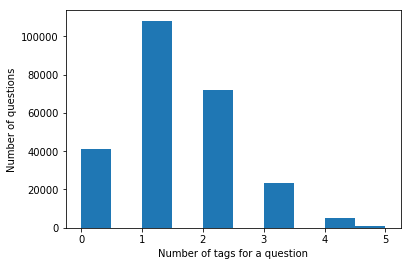

In [8]:
plt.hist(tags.sum(axis=1))
plt.xlabel('Number of tags for a question')
plt.ylabel('Number of questions')

### Split data into train, validation and test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(questions, tags, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5, 
                                                    random_state=random_state)

### Evaluation metrics

In [10]:
def eval_metrics(y_test, y_predicted, print_metrics=True):
    
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    if print_metrics:
        print("f1: %.3f - precision: %.3f - recall: %.3f - accuracy: %.3f" % (
            f1, precision, recall, accuracy))
    return accuracy, precision, recall, f1

# Simple first order model: Bag of words with logistic regression


### Bag of words embedding for quesitons

Remove common words and words appearing very less number of times from the corpus

In [29]:
def tokenize_question(text):
    return text.split()

bag_vect = CountVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=3,
                               max_df=0.5)

X_train_bag = bag_vect.fit_transform(X_train)
X_test_bag = bag_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(bag_vect.vocabulary_))

The number of words in the vocabulary is:  15909


### Logistic regression with binary relevance
Since this is a multi-label classificaiton, we will use binary relevance on top of logistical regression. This basically splits each label as a seperate classification. 

In [30]:
%%time
bag_log_clf = OneVsRestClassifier(LogisticRegression())

bag_log_clf.fit(X_train_bag, y_train)

print('Train score')
y_train_bag_predict = bag_log_clf.predict(X_train_bag)
eval_metrics(y_train, y_train_bag_predict)

print('Test score')
y_test_bag_predict = bag_log_clf.predict(X_test_bag)
eval_metrics(y_test, y_test_bag_predict)

Train score
f1: 0.583 - precision: 0.824 - recall: 0.462 - accuracy: 0.414
Test score
f1: 0.529 - precision: 0.747 - recall: 0.418 - accuracy: 0.360
CPU times: user 2min 58s, sys: 1min 50s, total: 4min 49s
Wall time: 1min 15s


### Important words

In [31]:
importances = importances = bag_log_clf.estimators_[0].coef_[0]
for i in range(1,len(bag_log_clf.estimators_)):
    importances += bag_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':bag_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)

,feature,importances,cum_imp
0,android,1.000000,0.002461
1,jquery,0.902750,0.004682
2,python,0.863801,0.006808
3,c++,0.801715,0.008781
4,r,0.789941,0.010725
5,java,0.786092,0.012659
6,spring,0.745138,0.014493
7,php,0.717334,0.016258
8,c#,0.713581,0.018014
9,django,0.702861,0.019744


## TFIDF with logistic regression and binary relevance

### TFIDF on bag of words embedding for quesitons

In [26]:
def tokenize_question(text):
    return text.split()

tfidf_vect = TfidfVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=4,
                               max_df=0.5)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(tfidf_vect.vocabulary_))

The number of words in the vocabulary is:  12965


### Logistic regression with binary relevance

In [27]:
%%time
tfidf_log_clf = OneVsRestClassifier(LogisticRegression())

tfidf_log_clf.fit(X_train_tfidf, y_train)

print('Train score')
y_train_tfidf_predict = tfidf_log_clf.predict(X_train_tfidf)
eval_metrics(y_train, y_train_tfidf_predict)

print('Test score')
y_test_tfidf_predict = tfidf_log_clf.predict(X_test_tfidf)
eval_metrics(y_test, y_test_tfidf_predict)

Train score
f1: 0.522 - precision: 0.806 - recall: 0.397 - accuracy: 0.372
Test score
f1: 0.501 - precision: 0.776 - recall: 0.379 - accuracy: 0.351
CPU times: user 3min 19s, sys: 2.89 s, total: 3min 22s
Wall time: 58 s


### Importance words

In [28]:
importances = importances = tfidf_log_clf.estimators_[0].coef_[0]
for i in range(1,len(tfidf_log_clf.estimators_)):
    importances += tfidf_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':tfidf_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)

,feature,importances,cum_imp
0,android,1.000000,0.064203
1,jquery,0.774219,0.113910
2,python,0.750050,0.162066
3,java,0.735756,0.209303
4,php,0.650266,0.251052
5,javascript,0.583658,0.288525
6,c++,0.536687,0.322982
7,c#,0.536018,0.357396
8,mysql,0.534831,0.391733
9,sql,0.526053,0.425508


# Convolutional sentence classification model

## Load Word2Vec

In [11]:
import gensim

word2vec_path = '../../../Data/stackoverflow/GoogleNews-vectors-negative300.bin.gz'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

### Hyerparameters related to sentece creation

In [20]:
max_seq_length = 35
vocab_size = 37000
embedding_size = 300

### Text preprocessing

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
tokenizer = Tokenizer(lower=True, split=' ', filters='')
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_size

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
seq_val = tokenizer.texts_to_sequences(X_val)

seq_length = [len(x) for x in seq_train]
max_seq_length = max(seq_length)

seq_train = pad_sequences(seq_train, maxlen=max_seq_length, padding='post', truncating='post')
seq_test = pad_sequences(seq_test, maxlen=max_seq_length, padding='post', truncating='post')
seq_val = pad_sequences(seq_val, maxlen=max_seq_length, padding='post', truncating='post')

embedding_weights = np.zeros((vocab_size+1, embedding_size))
word2vec_counter, randword_counter = 0, 0
for word, index in tokenizer.word_index.items():
    if index > vocab_size:
        break
        
    if word in word2vec:
        embedding_weights[index,:] = word2vec[word]
        word2vec_counter += 1
    else:
        embedding_weights[index,:] = np.random.normal(0, 0.15, embedding_size)
        randword_counter += 1
embedding_weights[0,:] = np.random.normal(0, 0.15, embedding_size)
print(embedding_weights.shape)

(37001, 300)


Text(0,0.5,'number')

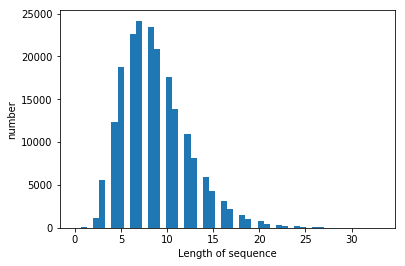

In [23]:
plt.hist(seq_length, bins=50)
plt.xlabel('Length of sequence')
plt.ylabel('number')

In [24]:
from model2 import ConvText
conv_model = ConvText(max_seq_length, max_tags, embedding_weights)


In [25]:
conv_model.fit(x=seq_train, y=y_train, batch_size=100, val_x=seq_val, val_y=y_val, epochs=10)

Epoch 1/10
200000/200000 [==============================] - 296s 1ms/step - Loss: 0.0579
Training Evaluation Metrics:
F1_score: 0.1795 - Precision: 0.4142 - Recall: 0.1191 - Acc: 0.2161
Validation evaluation metrics:
F1_score: 0.3493 - Precision: 0.5957 - Recall: 0.2632 - Acc: 0.2982 - Loss: 0.0395
Epoch 2/10
200000/200000 [==============================] - 310s 2ms/step - Loss: 0.0399
Training Evaluation Metrics:
F1_score: 0.3902 - Precision: 0.6505 - Recall: 0.2971 - Acc: 0.3029
Validation evaluation metrics:
F1_score: 0.4722 - Precision: 0.6729 - Recall: 0.3801 - Acc: 0.3509 - Loss: 0.0353
Epoch 3/10
200000/200000 [==============================] - 292s 1ms/step - Loss: 0.0359
Training Evaluation Metrics:
F1_score: 0.4584 - Precision: 0.6951 - Recall: 0.3618 - Acc: 0.3391
Validation evaluation metrics:
F1_score: 0.5022 - Precision: 0.6922 - Recall: 0.4070 - Acc: 0.3638 - Loss: 0.0343
Epoch 4/10
200000/200000 [==============================] - 294s 1ms/step - Loss: 0.0336
Training Ev